In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

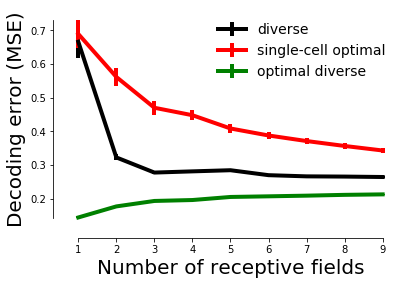

In [233]:
plt.errorbar(range(1, 10), diverse_means, yerr=diverse_errors, color='k', linewidth=4, label='diverse')
plt.errorbar(range(1, 10), homogenous_means, yerr=homogenous_errors, color='r', linewidth=4, label='single-cell optimal')
plt.errorbar(range(1, 10), mean_errors, yerr=sem_errors, color='g', linewidth=4, label='optimal diverse')
adjust_spines(plt.gca())
plt.xlabel('Number of receptive fields', fontsize=20)
plt.ylabel('Decoding error (MSE)', fontsize=20)
plt.legend(fontsize=14, frameon=False, loc='upper right')

In [234]:
mse_results = all_results
mse_errors = all_errors
mse_mean_errors = mean_errors
mse_sem_errors = sem_errors

# Try switching to tranpose convolutions instead of fully connected

In [235]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.5))
    ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.5))
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=21, padding='same')
    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.8294
Error at step 1000 is 0.0916
Error at step 2000 is 0.0666
Error at step 3000 is 0.0517
Error at step 4000 is 0.0418
Error at step 5000 is 0.0355
Error at step 6000 is 0.0310
Error at step 7000 is 0.0310
Error at step 8000 is 0.0278
Error at step 9000 is 0.0255
Error at step 10000 is 0.0265
Error at step 11000 is 0.0254
Error at step 12000 is 0.0246
Error at step 13000 is 0.0258
Error at step 14000 is 0.0254
Error at step 15000 is 0.0254
Error at step 16000 is 0.0253
Error at step 17000 is 0.0244
Error at step 18000 is 0.0247
Error at step 19000 is 0.0247
Error at step 20000 is 0.0238
Error at step 21000 is 0.0229
Error at step 22000 is 0.0248
Error at step 23000 is 0.0258
Error at step 24000 is 0.0235
Error at step 25000 is 0.0250
Error at step 26000 is 0.0257
Error at step 27000 is 0.0243

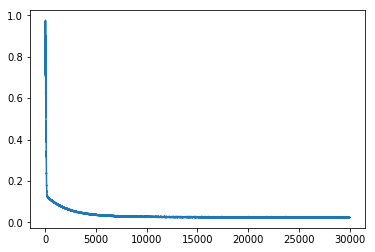

In [236]:
plt.plot(errors)

In [238]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.495655.
'optimal' cw is 1.154163.


In [245]:
len(results['output'])

31

In [251]:
np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)

0.023671657302691267

In [252]:
np.mean([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])

0.33600367522083591

In [254]:
results['output'][-1].shape

(128, 398, 1)

In [255]:
results['labels'][-1].shape

(128, 398)

In [256]:
results['input'][-1].shape

(128, 398, 1)

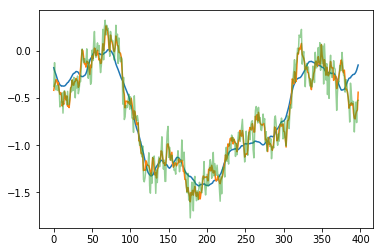

In [262]:
plt.plot(results['output'][-1][0])
plt.plot(results['labels'][-1][0])
plt.plot(results['input'][-1][0], alpha=0.5)

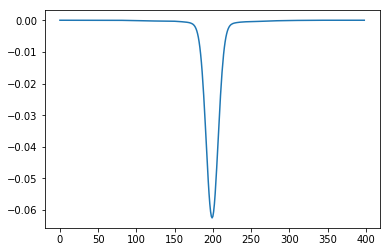

In [260]:
plt.plot(np.squeeze(results['kernel'][-1]))

In [274]:
len(results['kernel'][-1])

399

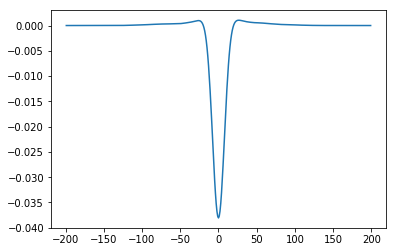

In [275]:
plt.plot(np.linspace(-398/2, 398/2, 399), np.squeeze(results['kernel'][-1]))

In [271]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=21, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 1.0609
Error at step 1000 is 0.1644
Error at step 2000 is 0.1162
Error at step 3000 is 0.0884
Error at step 4000 is 0.0680
Error at step 5000 is 0.0584
Error at step 6000 is 0.0515
Error at step 7000 is 0.0477
Error at step 8000 is 0.0473
Error at step 9000 is 0.0417
Error at step 10000 is 0.0397
Error at step 11000 is 0.0383
Error at step 12000 is 0.0375
Error at step 13000 is 0.0360
Error at step 14000 is 0.0369
Error at step 15000 is 0.0364
Error at step 16000 is 0.0372
Error at step 17000 is 0.0382
Error at step 18000 is 0.0354
Error at step 19000 is 0.0368
Error at step 20000 is 0.0343
Error at step 21000 is 0.0345
Error at step 22000 is 0.0347
Error at step 23000 is 0.0350
Error at step 24000 is 0.0327
Error at step 25000 is 0.0347
Error at step 26000 is 0.0338
Error at step 27000 is 0.0323

In [272]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.499782.
'optimal' cw is 0.809351.


In [ ]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 1.0017
Error at step 1000 is 0.1251
Error at step 2000 is 0.0904
Error at step 3000 is 0.0761
Error at step 4000 is 0.0612
Error at step 5000 is 0.0539
Error at step 6000 is 0.0480
Error at step 7000 is 0.0449
Error at step 8000 is 0.0413
Error at step 9000 is 0.0420
Error at step 10000 is 0.0424
Error at step 11000 is 0.0377
Error at step 12000 is 0.0386
Error at step 13000 is 0.0366
Error at step 14000 is 0.0362
Error at step 15000 is 0.0386
Error at step 16000 is 0.0349


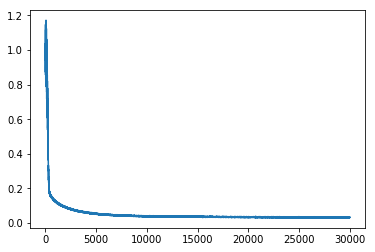

In [277]:
plt.plot(errors)

In [278]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.511873.
'optimal' cw is 0.729647.


In [279]:
results['decoder'][-1].shape

(200, 1, 1)

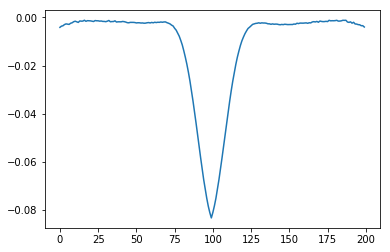

In [280]:
plt.plot(np.squeeze(results['decoder'][-1]))

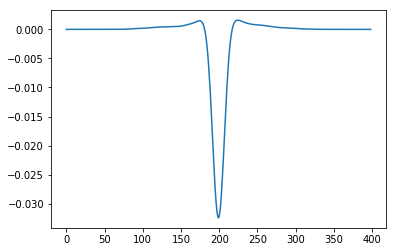

In [288]:
plt.plot(np.squeeze(results['kernel'])[-1])

In [305]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
stride = 5
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, int(output_len/stride) + 1))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=stride, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=50, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y[:,::stride]})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 80, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 80, 1), dtype=float32).
Out has shape (128, 80, 1).
Error at step 0000 is 0.9842
Error at step 1000 is 0.2005
Error at step 2000 is 0.1458
Error at step 3000 is 0.1183
Error at step 4000 is 0.0972
Error at step 5000 is 0.0880
Error at step 6000 is 0.0835
Error at step 7000 is 0.0736
Error at step 8000 is 0.0720
Error at step 9000 is 0.0727
Error at step 10000 is 0.0680
Error at step 11000 is 0.0657
Error at step 12000 is 0.0643
Error at step 13000 is 0.0645
Error at step 14000 is 0.0647
Error at step 15000 is 0.0642
Error at step 16000 is 0.0585
Error at step 17000 is 0.0584
Error at step 18000 is 0.0605
Error at step 19000 is 0.0587
Error at step 20000 is 0.0597
Error at step 21000 is 0.0545
Error at step 22000 is 0.0605
Error at step 23000 is 0.0575
Error at step 24000 is 0.0542
Error at step 25000 is 0.0604
Error at step 26000 is 0.0606
Error at step 27000 is 0.0583
Er

ValueError: operands could not be broadcast together with shapes (128,80) (128,398) 

In [306]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.513181.
'optimal' cw is 0.812676.


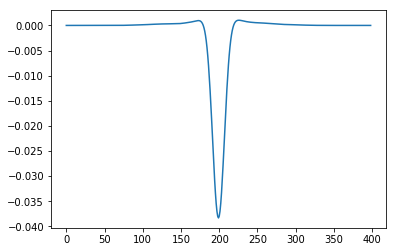

In [307]:
plt.plot(np.squeeze(results['kernel'])[-1])

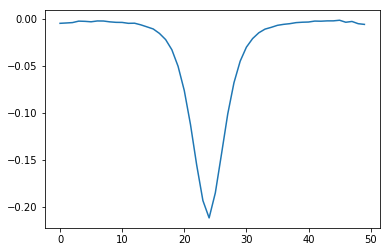

In [308]:
plt.plot(np.squeeze(results['decoder'])[-1])

# Variance

In [317]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
stride = 20
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, int(output_len/stride) + 1))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=stride, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=50, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    # mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    mean, var = tf.nn.moments(label - tf.squeeze(out), axes=[1])
    mse = tf.reduce_mean(tf.log(var))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y[:,::stride]})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 20, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 20, 1), dtype=float32).
Out has shape (128, 20, 1).
Error at step 0000 is -1.4278
Error at step 1000 is -1.9065
Error at step 2000 is -2.1267
Error at step 3000 is -2.4110
Error at step 4000 is -2.6936
Error at step 5000 is -2.7634
Error at step 6000 is -2.8217
Error at step 7000 is -2.8128
Error at step 8000 is -2.8564
Error at step 9000 is -2.7975
Error at step 10000 is -2.8558
Error at step 11000 is -2.8826
Error at step 12000 is -2.9621
Error at step 13000 is -2.8807
Error at step 14000 is -2.9137
Error at step 15000 is -2.8963
Error at step 16000 is -2.9094
Error at step 17000 is -2.9098
Error at step 18000 is -2.8528
Error at step 19000 is -2.8892
Error at step 20000 is -2.9269
Error at step 21000 is -2.9371
Error at step 22000 is -2.9569
Error at step 23000 is -2.9658
Error at step 24000 is -2.9967
Error at step 25000 is -2.9027
Error at step 26000 is -2.9289
Error

ValueError: operands could not be broadcast together with shapes (128,20) (128,398) 

In [318]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.533471.
'optimal' cw is 0.973740.


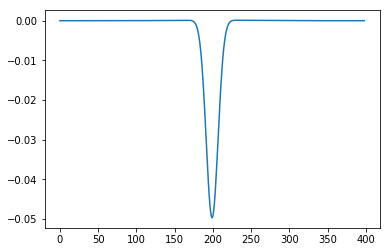

In [319]:
plt.plot(np.squeeze(results['kernel'])[-1])

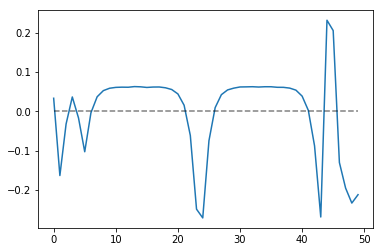

In [320]:
plt.plot(np.squeeze(results['decoder'])[-1])
plt.plot([0]*50, 'k--', alpha=0.5)

# Constrain SNR

In [65]:
from surround.efficient_coding import get_snr

In [66]:
# From notebook Surround - 5-7 All of Figure 3 from scratch
target_snr = 0.26912469

In [328]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    signal_mean, signal_var = tf.nn.moments(tf.squeeze(label), axes=[1])
    # noise_mean, noise_var = tf.nn.moments(tf.squeeze(noisy_encoded), axes=[1]) # shouldn't this be input_noise convolved with filter + output_noise?
    # in_noise = tf.constant(input_noise, dtype=tf.float32, shape=tf.squeeze(label).shape)
    in_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=input_noise, name='input_noise')
    all_noise = tf.nn.conv1d(in_noise, kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    #snr = tf.where(tf.equal(noise_var, tf.constant(0.0, dtype=tf.float32)), 0.0, signal_var/noise_var)
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr],
                feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.9252
Error at step 1000 is 0.1349
Error at step 2000 is 0.1005
Error at step 3000 is 0.0779
Error at step 4000 is 0.0626
Error at step 5000 is 0.0534
Error at step 6000 is 0.0492
Error at step 7000 is 0.0459
Error at step 8000 is 0.0425
Error at step 9000 is 0.0410
Error at step 10000 is 0.0380
Error at step 11000 is 0.0376
Error at step 12000 is 0.0366
Error at step 13000 is 0.0371
Error at step 14000 is 0.0360
Error at step 15000 is 0.0361
Error at step 16000 is 0.0343
Error at step 17000 is 0.0346
Error at step 18000 is 0.0342
Error at step 19000 is 0.0314
Error at step 20000 is 0.0325
Error at step 21000 is 0.0322
Error at step 22000 is 0.0324
Error at step 23000 is 0.0300
Error at step 24000 is 0.0313
Error at step 25000 is 0.0319
Error at step 26000 is 0.0318
Error at step 27000 is 0.0315

In [329]:
results['snr'][-1]

array([ 1.73523641,  0.55353099,  0.98976433,  2.63795018,  0.75600672,
        0.86810493,  1.87275195,  3.00374866,  3.06381941,  2.57032013,
        1.50535381,  1.78393126,  1.19988823,  0.72916251,  5.91553354,
        1.49202621,  1.08618522,  1.31746554,  0.75099128,  0.83880693,
        1.24390984,  2.48789334,  0.93207914,  2.84842968,  0.86101013,
        1.77026796,  1.76822495,  0.67572105,  5.79053879,  0.55983239,
        0.52552974,  0.7685042 ,  0.62303764,  2.72895241,  1.45692766,
        2.60547256,  0.78656352,  1.56268549,  1.07738984,  2.15688205,
        0.4742862 ,  1.70171297,  1.11587703,  3.57889748,  2.12370062,
        2.23604536,  0.37308508,  1.17242718,  3.82869744,  2.28609824,
        1.6425004 ,  2.15047336,  1.92184484,  0.6062603 ,  0.63256931,
        0.97189707,  1.36501622,  1.58914745,  1.20956004,  0.86557156,
        1.81406474,  1.90742254,  0.68048644,  4.95617008,  1.49129915,
        0.58046424,  3.30204201,  3.20519042,  2.39567733,  2.42

In [330]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.517523.
'optimal' cw is 0.768956.


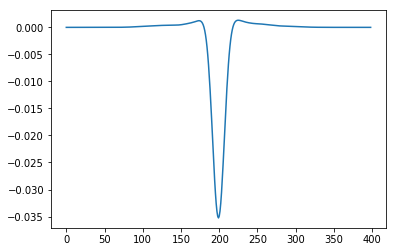

In [333]:
plt.plot(np.squeeze(results['kernel'][-1]))

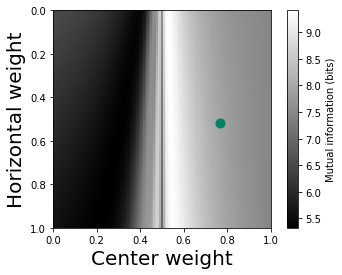

In [331]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

# May also want to use nonlinear decoding, where maximizing information may be more useful, compared to just using a linear readout

In [342]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(1,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_3:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.9228
Error at step 1000 is 0.0882
Error at step 2000 is 0.0739
Error at step 3000 is 0.0647
Error at step 4000 is 0.0612
Error at step 5000 is 0.0580
Error at step 6000 is 0.0559
Error at step 7000 is 0.0503
Error at step 8000 is 0.0496
Error at step 9000 is 0.0516
Error at step 10000 is 0.0465
Error at step 11000 is 0.0472
Error at step 12000 is 0.0459
Error at step 13000 is 0.0476
Error at step 14000 is 0.0426
Error at step 15000 is 0.0419
Error at step 16000 is 0.0439
Error at step 17000 is 0.0441
Error at step 18000 is 0.0428
Error at step 19000 is 0.0400
Error at step 20000 is 0.0425
Error at step 21000 is 0.0426
Error at step 22000 is 0.0416


KeyboardInterrupt: 

In [343]:
results['snr'][-1]

array([[ 0.17443579,  0.17650789,  0.16405828, ...,  0.17950362,
         0.1703596 ,  0.18328629],
       [ 0.13245729,  0.13403071,  0.12457715, ...,  0.13630553,
         0.12936203,  0.13917789],
       [ 0.11575479,  0.11712983,  0.10886832, ...,  0.11911778,
         0.11304985,  0.12162795],
       ..., 
       [ 0.1563981 ,  0.15825593,  0.14709368, ...,  0.16094188,
         0.15274341,  0.1643334 ],
       [ 0.33644667,  0.34044325,  0.31643084, ...,  0.34622136,
         0.32858464,  0.35351726],
       [ 0.21284328,  0.21537162,  0.20018084, ...,  0.21902697,
         0.20786959,  0.22364251]], dtype=float32)

In [350]:
np.mean(results['snr'][-1])

0.21583024

In [344]:
results['snr_reg'][-1]

0.017761048

In [345]:
results['input_noise'][-1]

array([ 0.04012606], dtype=float32)

In [346]:
results['output_noise'][-1]

array([ 0.24284503], dtype=float32)

In [347]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.489452.
'optimal' cw is 0.574923.


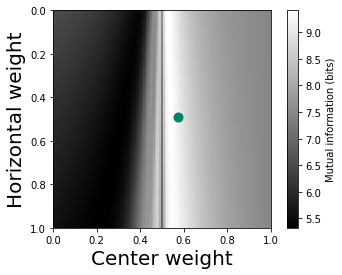

In [349]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [348]:
output_noise

0.35

In [351]:
constrained_filter1_results = results

In [352]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 2
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(1,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_5:0", shape=(128, 398, 2), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.8180
Error at step 1000 is 0.0839
Error at step 2000 is 0.0705
Error at step 3000 is 0.0681
Error at step 4000 is 0.0581
Error at step 5000 is 0.0569
Error at step 6000 is 0.0551
Error at step 7000 is 0.0538
Error at step 8000 is 0.0482
Error at step 9000 is 0.0474
Error at step 10000 is 0.0437
Error at step 11000 is 0.0440
Error at step 12000 is 0.0405
Error at step 13000 is 0.0394
Error at step 14000 is 0.0381
Error at step 15000 is 0.0374
Error at step 16000 is 0.0374
Error at step 17000 is 0.0350
Error at step 18000 is 0.0344
Error at step 19000 is 0.0357
Error at step 20000 is 0.0342
Error at step 21000 is 0.0334
Error at step 22000 is 0.0312
Error at step 23000 is 0.0323
Error at step 24000 is 0.0316
Error at step 25000 is 0.0316
Error at step 26000 is 0.0311
Error at step 27000 is 0.0322

In [355]:
np.mean(results['snr'][-1])

0.23850752

In [353]:
print("'optimal' hw is %s." %results['hw'][-1])
print("'optimal' cw is %s." %results['cw'][-1])

'optimal' hw is [ 0.47837314  0.49567163].
'optimal' cw is [ 0.56802303  0.56579578].


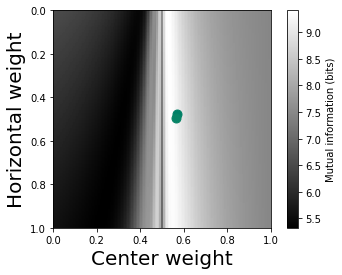

In [354]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [360]:
constrained_filter2_results = results

# Try with variable output noise for each channel

In [361]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 2
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_5:0", shape=(128, 398, 2), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.9929
Error at step 1000 is 0.0790
Error at step 2000 is 0.0623
Error at step 3000 is 0.0571
Error at step 4000 is 0.0532
Error at step 5000 is 0.0504
Error at step 6000 is 0.0488
Error at step 7000 is 0.0455
Error at step 8000 is 0.0439
Error at step 9000 is 0.0440
Error at step 10000 is 0.0424
Error at step 11000 is 0.0405
Error at step 12000 is 0.0400
Error at step 13000 is 0.0406
Error at step 14000 is 0.0392
Error at step 15000 is 0.0394
Error at step 16000 is 0.0395
Error at step 17000 is 0.0375
Error at step 18000 is 0.0375
Error at step 19000 is 0.0348
Error at step 20000 is 0.0370
Error at step 21000 is 0.0347
Error at step 22000 is 0.0339
Error at step 23000 is 0.0367
Error at step 24000 is 0.0343
Error at step 25000 is 0.0343
Error at step 26000 is 0.0350
Error at step 27000 is 0.0343

In [363]:
np.mean(results['snr'][-1])

0.22729078

In [362]:
print("'optimal' hw is %s." %results['hw'][-1])
print("'optimal' cw is %s." %results['cw'][-1])

'optimal' hw is [ 0.490969    0.49000093].
'optimal' cw is [ 0.49360722  0.57845408].


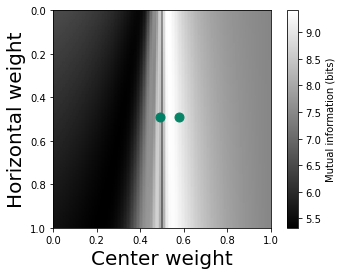

In [364]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [365]:
results['output_noise'][-1]

array([ 0.15106282,  0.24494569], dtype=float32)

In [367]:
results['input_noise'][-1]

array([ 0.0184157], dtype=float32)

In [368]:
def sigmoid(x, gain=1.0, threshold=0.0):
    return 1./(1. + np.exp(-gain*(x - threshold)))

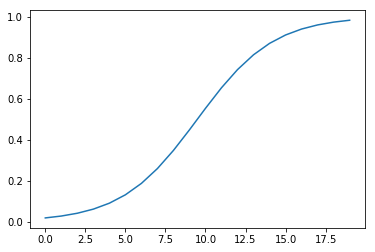

In [375]:
plt.plot(sigmoid(np.linspace(-10,10,20), gain=0.4))

# Try a lower gain on the sigmoid parameterization

In [376]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 2
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(1.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(1.0))
    ideal_horz_weights = tf.nn.sigmoid(0.2 * hw_param)
    ideal_center_weights = tf.nn.sigmoid(0.2 * cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_5:0", shape=(128, 398, 2), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 1.2627
Error at step 1000 is 0.0894
Error at step 2000 is 0.0726
Error at step 3000 is 0.0660
Error at step 4000 is 0.0604
Error at step 5000 is 0.0571
Error at step 6000 is 0.0520
Error at step 7000 is 0.0526
Error at step 8000 is 0.0477
Error at step 9000 is 0.0448
Error at step 10000 is 0.0444
Error at step 11000 is 0.0413
Error at step 12000 is 0.0432
Error at step 13000 is 0.0405
Error at step 14000 is 0.0386
Error at step 15000 is 0.0376
Error at step 16000 is 0.0377
Error at step 17000 is 0.0367
Error at step 18000 is 0.0387
Error at step 19000 is 0.0336
Error at step 20000 is 0.0359
Error at step 21000 is 0.0345
Error at step 22000 is 0.0353
Error at step 23000 is 0.0332
Error at step 24000 is 0.0339
Error at step 25000 is 0.0326
Error at step 26000 is 0.0339
Error at step 27000 is 0.0328

In [377]:
print("'optimal' hw is %s." %results['hw'][-1])
print("'optimal' cw is %s." %results['cw'][-1])

'optimal' hw is [ 0.54919183  0.54927063].
'optimal' cw is [ 0.55653816  0.55640829].


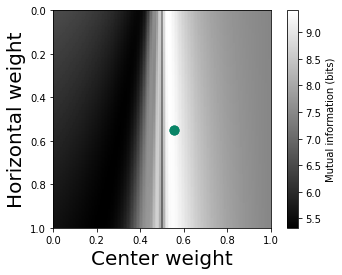

In [378]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

# Randomly initialize everything

In [397]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 2
gain = 0.6
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    # RANDOMLY INITIALIZE
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.random_uniform_initializer(minval=-3, maxval=3))
    #cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
    #                                       initializer=tf.random_uniform_initializer(minval=-3, maxval=3))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                               initializer=tf.constant_initializer(1.0))

    ideal_horz_weights = tf.nn.sigmoid(gain * hw_param)
    ideal_center_weights = tf.nn.sigmoid(gain * cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.01)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_5:0", shape=(128, 398, 2), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.4515
Error at step 1000 is 0.0340
Error at step 2000 is 0.0297
Error at step 3000 is 0.0300
Error at step 4000 is 0.0298
Error at step 5000 is 0.0281
Error at step 6000 is 0.0293
Error at step 7000 is 0.0298
Error at step 8000 is 0.0298
Error at step 9000 is 0.0293
Error at step 10000 is 0.0287
Error at step 11000 is 0.0295
Error at step 12000 is 0.0301
Error at step 13000 is 0.0292
Error at step 14000 is 0.0295
Error at step 15000 is 0.0276
Error at step 16000 is 0.0291
Error at step 17000 is 0.0295
Error at step 18000 is 0.0311
Error at step 19000 is 0.0286
Error at step 20000 is 0.0301
Error at step 21000 is 0.0311
Error at step 22000 is 0.0295
Error at step 23000 is 0.0305
Error at step 24000 is 0.0315
Error at step 25000 is 0.0294
Error at step 26000 is 0.0290
Error at step 27000 is 0.0314

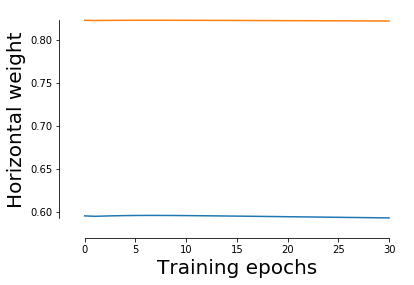

In [403]:
plt.plot(np.stack(results['hw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)
adjust_spines(plt.gca())

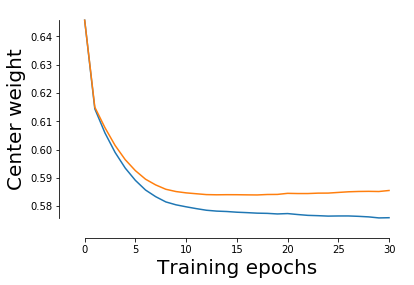

In [407]:
plt.plot(np.stack(results['cw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

In [400]:
print("'optimal' hw is %s." %results['hw'][-1])
print("'optimal' cw is %s." %results['cw'][-1])

'optimal' hw is [ 0.59272063  0.821962  ].
'optimal' cw is [ 0.57590818  0.58552206].


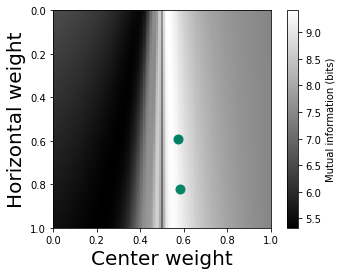

In [401]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

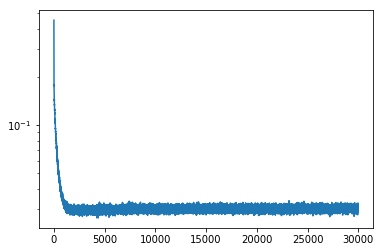

In [405]:
plt.plot(errors)
plt.yscale('log')

In [409]:
results_lr01 = results
errors_lr01 = errors

# Decrease learning rate

In [410]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 2
gain = 0.6
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    # RANDOMLY INITIALIZE
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.random_uniform_initializer(minval=-3, maxval=3))
    #cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
    #                                       initializer=tf.random_uniform_initializer(minval=-3, maxval=3))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                               initializer=tf.constant_initializer(1.0))

    ideal_horz_weights = tf.nn.sigmoid(gain * hw_param)
    ideal_center_weights = tf.nn.sigmoid(gain * cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_5:0", shape=(128, 398, 2), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.5239
Error at step 1000 is 0.1172
Error at step 2000 is 0.0853
Error at step 3000 is 0.0687
Error at step 4000 is 0.0576
Error at step 5000 is 0.0491
Error at step 6000 is 0.0417
Error at step 7000 is 0.0385
Error at step 8000 is 0.0367
Error at step 9000 is 0.0353
Error at step 10000 is 0.0341
Error at step 11000 is 0.0311
Error at step 12000 is 0.0304
Error at step 13000 is 0.0304
Error at step 14000 is 0.0309
Error at step 15000 is 0.0294
Error at step 16000 is 0.0308
Error at step 17000 is 0.0298
Error at step 18000 is 0.0277
Error at step 19000 is 0.0309
Error at step 20000 is 0.0286
Error at step 21000 is 0.0304
Error at step 22000 is 0.0283
Error at step 23000 is 0.0292
Error at step 24000 is 0.0282
Error at step 25000 is 0.0289
Error at step 26000 is 0.0287
Error at step 27000 is 0.0292

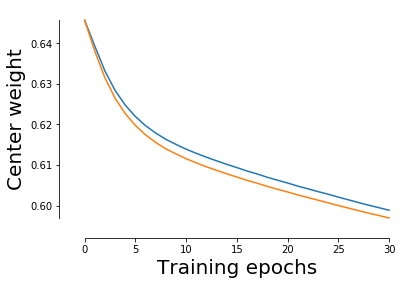

In [411]:
plt.plot(np.stack(results['cw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

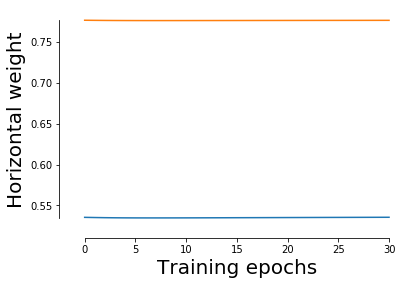

In [413]:
plt.plot(np.stack(results['hw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

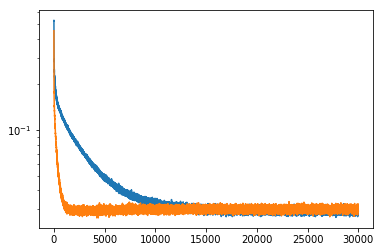

In [414]:
plt.plot(errors)
plt.plot(errors_lr01)
plt.yscale('log')

# Now for many different channel widths

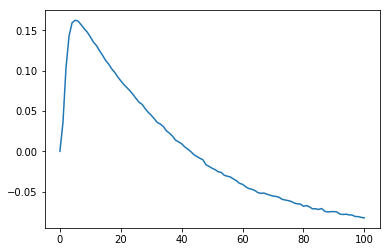

In [103]:
plt.plot(all_results[0]['hw'])

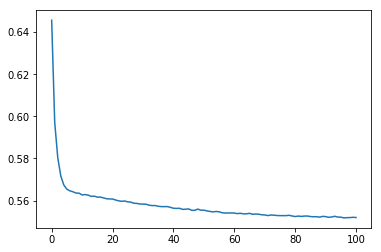

In [102]:
plt.plot(all_results[0]['cw'])

In [105]:
constants = {
    'microns_per_degree': microns_per_degree,
    'pixelsToDeg': pixelsToDeg,
    'photoreceptor_width': photoreceptor_width,
    'retina_width': retina_width,
    'frequency_spacing': frequency_spacing,
    'highest_frequency': highest_frequency,
    'receptive_fields': receptive_fields,
    'N': N,
    'freqs': freqs,
    'space': space,
    'spacing': spacing,
    'contrast': contrast,
    'center_widths': center_widths,
    'surround_widths': surround_widths,
    'center_strengths': center_strengths,
    'surround_strengths': surround_strengths,
    'fit_failures': fit_failures,
    'median_center_widths': median_center_widths,
    'horz_pf': horz_pf,
    'ama_pf': ama_pf,
    'target_power': target_power,
    'resolution': resolution,
    'info_maps': info_maps,
    'failures': failures,
    'detailed_failures': detailed_failures,
    'celltype': celltype,
    'center': center,
    'input_noise': input_noise,
    'output_noise': output_noise,
    'target_snr': target_snr
}

In [106]:
np.save('/home/lane/code/ipython-notebooks/baccuslab/2017_10_9_diversity_constants.npy', constants)

In [101]:
with tf.device('/gpu:0'):
    batch_size = 128
    input_len = x.shape[1]
    output_len = y.shape[1]
    max_steps = 100000
    mean_errors = []
    sem_errors = []
    max_channel_depth = 10
    all_results = []
    all_errors = []
    lr = 0.01
    gain = 0.6
    random_initialization = False

    for channel_depth in range(1, max_channel_depth+1):
        # Universal variables
        results = collections.defaultdict(list)

        g = tf.Graph()
        errors = []
        with g.as_default():
            # GET INPUT and OUTPUT NOISE
            n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                                 initializer=tf.constant_initializer(input_noise))
            n_out = tf.get_variable('noise_out', shape=(channel_depth,), dtype=tf.float32,
                                                   initializer=tf.constant_initializer(output_noise))
            # GET DATA READY
            # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
            label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
            in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
            noisy_input = label + in_noise
            # inputs, num_outputs, kernel_size, stride=1

            # GET FILTERS READY
            # RANDOMLY INITIALIZE
            if random_initialization:
                hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                                     initializer=tf.random_uniform_initializer(minval=0, maxval=1))
            else:
                hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                                     initializer=tf.constant_initializer(0.0))
            #cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
            #                                       initializer=tf.random_uniform_initializer(minval=-3, maxval=3))
            cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                       initializer=tf.constant_initializer(1.0))

            ideal_horz_weights = hw_param #tf.nn.sigmoid(gain * hw_param)
            ideal_center_weights = tf.nn.sigmoid(gain * cw_param)
            filters = []
            filtered_output = []
            for c in range(channel_depth):
                # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
                filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
            kernel = tf.stack(filters, axis=-1)
            kernel = tf.expand_dims(kernel, axis=1)
            print('Kernel has shape %s.' %(kernel.shape,))

            # CONVOLUTION WITH IDEAL RFS
            distortion = tf.expand_dims(noisy_input, axis=-1)
            encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
            out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
            noisy_encoded = encoded + out_noise
            print('Encoded has shape %s.' %(encoded.shape,))
            print('Noisy encoded has shape %s.' %(noisy_encoded,))

            # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
            # out = tf.layers.dense(flattened_input, output_len)
            # print('Flattened input has shape %s.' %(flattened_input.shape,))

            out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
            variables = tf.get_collection(tf.GraphKeys.VARIABLES)
            weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
            print('Out has shape %s.' %(out.shape,))

            signal_mean, signal_var = tf.nn.moments(
                tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
            all_noise = tf.nn.conv1d(
                tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
            noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
            snr = signal_var/noise_var
            snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                              snr)

            mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
            loss = mse + 2. * snr_regularization
            opt = tf.train.GradientDescentOptimizer(lr)
            train_op = opt.minimize(loss)

            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for step in range(max_steps):
                    x, y = training_data(batch_size)
                    update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                        [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                         n_in, n_out],
                        feed_dict={label: y})
                    errors.append(error)
                    if step % 1000 == 0:
                        print('Error at step %04d is %0.4f' %(step, error))
                        results['input'].append(x)
                        results['labels'].append(y)
                        output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                        results['output'].append(output)
                        results['kernel'].append(k)
                        results['hw'].append(hw)
                        results['cw'].append(cw)
                        results['decoder'].append(decoder)
                        results['snr'].append(this_snr)
                        results['snr_reg'].append(snr_reg)
                        results['input_noise'].append(ni)
                        results['output_noise'].append(no)
                    elif step == max_steps - 1:
                        print('Error at step %04d is %0.4f' %(step, error))
                        results['input'].append(x)
                        results['labels'].append(y)
                        output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                        results['output'].append(output)
                        results['kernel'].append(k)
                        results['hw'].append(hw)
                        results['cw'].append(cw)
                        results['decoder'].append(decoder)
                        results['snr'].append(this_snr)
                        results['snr_reg'].append(snr_reg)
                        results['input_noise'].append(ni)
                        results['output_noise'].append(no)

        # Collect results.
        this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
        # np.mean([np.mean(
        #    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
        this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
        # this_err = sem([np.mean(
        #    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])

        mean_errors.append(this_mse)
        sem_errors.append(this_err)
        all_results.append(results)
        all_errors.append(errors)
        tf.reset_default_graph()

Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_3:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.6979
Error at step 1000 is 0.0459
Error at step 2000 is 0.0408
Error at step 3000 is 0.0383
Error at step 4000 is 0.0410
Error at step 5000 is 0.0437
Error at step 6000 is 0.0416
Error at step 7000 is 0.0446
Error at step 8000 is 0.0411
Error at step 9000 is 0.0388
Error at step 10000 is 0.0407
Error at step 11000 is 0.0410
Error at step 12000 is 0.0379
Error at step 13000 is 0.0413
Error at step 14000 is 0.0401
Error at step 15000 is 0.0412
Error at step 16000 is 0.0412
Error at step 17000 is 0.0405
Error at step 18000 is 0.0395
Error at step 19000 is 0.0389
Error at step 20000 is 0.0413
Error at step 21000 is 0.0419
Error at step 22000 is 0.0399
Error at step 23000 is 0.0397
Error at step 24000 is 0.0410
Error at step 25000 is 0.0402
Error at step 26000 is 0.0398
Error at step 27000 is 0.0430

KeyboardInterrupt: 

In [ ]:
homogenous_mean_errors = mean_errors
homogenous_sem_errors = sem_errors
homogenous_all_results = all_results
homogenous_all_errors = all_errors

In [ ]:
np.save('/home/lane/code/ipython-notebooks/baccuslab/2017_10_9_diversity_results.npy', all_results)

In [ ]:
np.save('/home/lane/code/ipython-notebooks/baccuslab/2017_10_9_diversity_mean_errors.npy', mean_errors)
np.save('/home/lane/code/ipython-notebooks/baccuslab/2017_10_9_diversity_sem_errors.npy', sem_errors)
np.save('/home/lane/code/ipython-notebooks/baccuslab/2017_10_9_diversity_all_errors.npy', all_errors)

In [ ]:
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
max_channel_depth = 10
all_results = []
all_errors = []
lr = 0.01
gain = 0.6
random_initialization = True

for channel_depth in range(1, max_channel_depth+1):
    # Universal variables
    results = collections.defaultdict(list)

    g = tf.Graph()
    errors = []
    with g.as_default():
        # GET INPUT and OUTPUT NOISE
        n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                             initializer=tf.constant_initializer(input_noise))
        n_out = tf.get_variable('noise_out', shape=(channel_depth,), dtype=tf.float32,
                                               initializer=tf.constant_initializer(output_noise))
        # GET DATA READY
        # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
        label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
        in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
        noisy_input = label + in_noise
        # inputs, num_outputs, kernel_size, stride=1

        # GET FILTERS READY
        # RANDOMLY INITIALIZE
        if random_initialization:
            hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                                 initializer=tf.random_uniform_initializer(minval=0, maxval=1))
        else:
            hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                                 initializer=tf.constant_initializer(0.0))
        #cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
        #                                       initializer=tf.random_uniform_initializer(minval=-3, maxval=3))
        cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                   initializer=tf.constant_initializer(1.0))

        ideal_horz_weights = hw_param #tf.nn.sigmoid(gain * hw_param)
        ideal_center_weights = tf.nn.sigmoid(gain * cw_param)
        filters = []
        filtered_output = []
        for c in range(channel_depth):
            # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
            filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
        kernel = tf.stack(filters, axis=-1)
        kernel = tf.expand_dims(kernel, axis=1)
        print('Kernel has shape %s.' %(kernel.shape,))

        # CONVOLUTION WITH IDEAL RFS
        distortion = tf.expand_dims(noisy_input, axis=-1)
        encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
        out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
        noisy_encoded = encoded + out_noise
        print('Encoded has shape %s.' %(encoded.shape,))
        print('Noisy encoded has shape %s.' %(noisy_encoded,))

        # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
        # out = tf.layers.dense(flattened_input, output_len)
        # print('Flattened input has shape %s.' %(flattened_input.shape,))

        out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
        variables = tf.get_collection(tf.GraphKeys.VARIABLES)
        weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
        print('Out has shape %s.' %(out.shape,))

        signal_mean, signal_var = tf.nn.moments(
            tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
        all_noise = tf.nn.conv1d(
            tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
        noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
        snr = signal_var/noise_var
        snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                          snr)

        mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
        loss = mse + 2. * snr_regularization
        opt = tf.train.GradientDescentOptimizer(lr)
        train_op = opt.minimize(loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for step in range(max_steps):
                x, y = training_data(batch_size)
                update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                    [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                     n_in, n_out],
                    feed_dict={label: y})
                errors.append(error)
                if step % 1000 == 0:
                    print('Error at step %04d is %0.4f' %(step, error))
                    results['input'].append(x)
                    results['labels'].append(y)
                    output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                    results['output'].append(output)
                    results['kernel'].append(k)
                    results['hw'].append(hw)
                    results['cw'].append(cw)
                    results['decoder'].append(decoder)
                    results['snr'].append(this_snr)
                    results['snr_reg'].append(snr_reg)
                    results['input_noise'].append(ni)
                    results['output_noise'].append(no)
                elif step == max_steps - 1:
                    print('Error at step %04d is %0.4f' %(step, error))
                    results['input'].append(x)
                    results['labels'].append(y)
                    output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                    results['output'].append(output)
                    results['kernel'].append(k)
                    results['hw'].append(hw)
                    results['cw'].append(cw)
                    results['decoder'].append(decoder)
                    results['snr'].append(this_snr)
                    results['snr_reg'].append(snr_reg)
                    results['input_noise'].append(ni)
                    results['output_noise'].append(no)

    # Collect results.
    this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
    # np.mean([np.mean(
    #    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
    this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
    # this_err = sem([np.mean(
    #    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])

    mean_errors.append(this_mse)
    sem_errors.append(this_err)
    all_results.append(results)
    all_errors.append(errors)
    tf.reset_default_graph()

In [420]:
len(all_errors[0])

30000

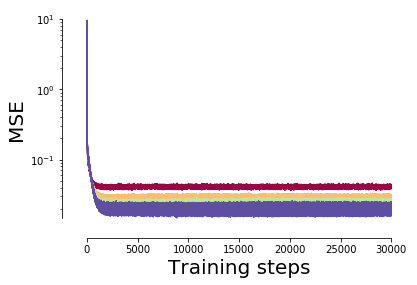

In [74]:
colors = plt.cm.Spectral(np.linspace(0,3,max_channel_depth))
for ide, e in enumerate(all_errors):
    plt.plot(e, color=colors[ide], label='%d channels' %(ide+1))
plt.yscale('log')
adjust_spines(plt.gca())
plt.ylabel('MSE', fontsize=20)
plt.xlabel('Training steps', fontsize=20)
# plt.legend(loc='upper right', frameon=False, fontsize=12)

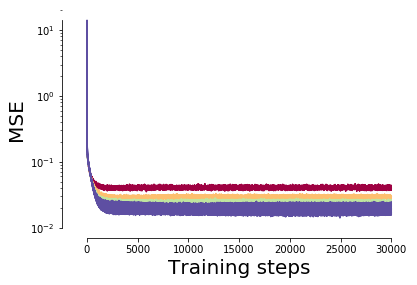

In [78]:
colors = plt.cm.Spectral(np.linspace(0,3,max_channel_depth))
for ide, e in enumerate(homogenous_all_errors):
    plt.plot(e, color=colors[ide], label='%d channels' %(ide+1))
plt.yscale('log')
adjust_spines(plt.gca())
plt.ylabel('MSE', fontsize=20)
plt.xlabel('Training steps', fontsize=20)
# plt.legend(loc='upper right', frameon=False, fontsize=12)

In [80]:
len(homogenous_all_errors[0])

30000

In [82]:
mean_homogenous_errors = [np.mean(homogenous_all_errors[i][-1000:]) for i in range(max_channel_depth)]
mean_diverse_errors = [np.mean(all_errors[i][-1000:]) for i in range(max_channel_depth)]

In [83]:
mean_homogenous_errors

[0.040457617,
 0.0293105,
 0.024428289,
 0.022433702,
 0.020743057,
 0.019674443,
 0.01860865,
 0.017711533,
 0.016984932,
 0.016625941]

In [84]:
mean_diverse_errors

[0.040886879,
 0.02997596,
 0.025620937,
 0.023070619,
 0.02132355,
 0.020282738,
 0.01915825,
 0.018234862,
 0.017372115,
 0.016971879]

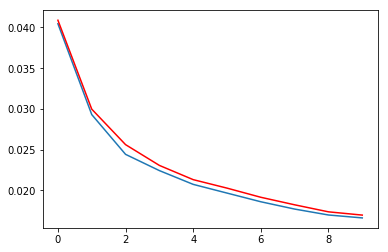

In [85]:
plt.plot(mean_homogenous_errors)
plt.plot(mean_diverse_errors, 'r')

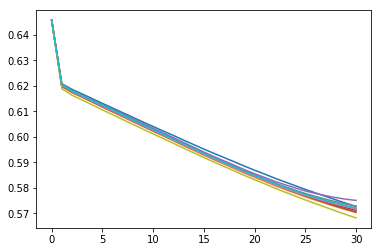

In [95]:
_ = plt.plot(all_results[-1]['cw'])

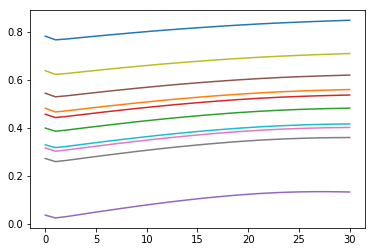

In [96]:
_ = plt.plot(all_results[-1]['hw'])

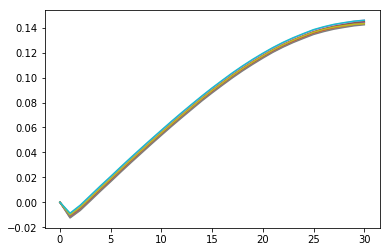

In [97]:
_ = plt.plot(homogenous_all_results[-1]['hw'])

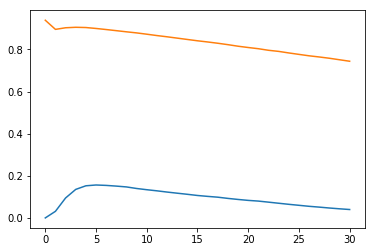

In [100]:
_ = plt.plot(homogenous_all_results[0]['hw'])
_ = plt.plot(all_results[0]['hw'])

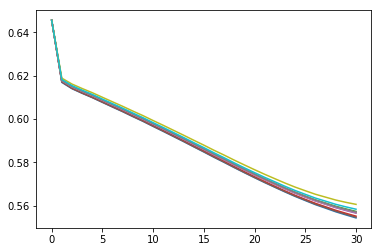

In [98]:
_ = plt.plot(homogenous_all_results[-1]['cw'])

(0, 1)

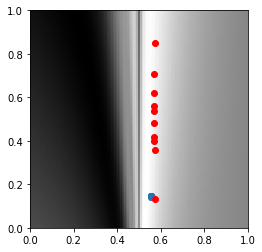

In [93]:
plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
plt.scatter(homogenous_all_results[-1]['cw'][-1], homogenous_all_results[-1]['hw'][-1])
plt.scatter(all_results[-1]['cw'][-1], all_results[-1]['hw'][-1], color='r')
plt.ylim(0,1)
plt.xlim(0,1)

In [89]:
homogenous_all_results[-1]['cw'][-1]

array([ 0.55430555,  0.5567019 ,  0.55728859,  0.55511463,  0.55650377,
        0.55468947,  0.55686325,  0.55698782,  0.56056893,  0.55832624], dtype=float32)

In [88]:
homogenous_all_results[-1]['hw'][-1]

array([ 0.14514522,  0.14295828,  0.14404492,  0.14419974,  0.14446889,
        0.14494129,  0.14596899,  0.1423844 ,  0.14328572,  0.14601141], dtype=float32)

In [86]:
all_results[-1]['hw'][-1]

array([ 0.84760028,  0.55902576,  0.48140588,  0.53616631,  0.13222286,
        0.61920631,  0.40110084,  0.35921985,  0.70908016,  0.41581616], dtype=float32)

In [77]:
all_results[-1]['cw'][-1]

array([ 0.57269865,  0.57033712,  0.57176095,  0.57120997,  0.57508403,
        0.57056665,  0.57178342,  0.57284617,  0.56822211,  0.5721162 ], dtype=float32)

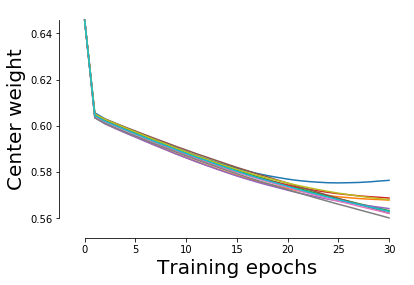

In [456]:
plt.plot(np.stack(all_results[-1]['cw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

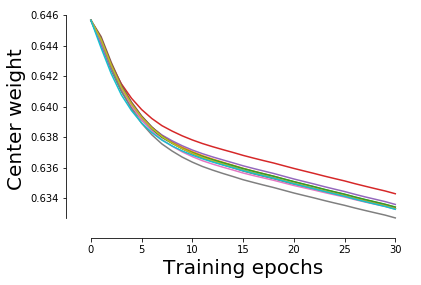

In [447]:
plt.plot(np.stack(all_results[-1]['cw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

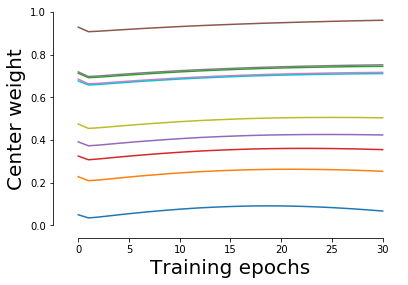

In [458]:
plt.plot(np.stack(all_results[-1]['hw']))
plt.xlabel('Training epochs', fontsize=20)
plt.ylabel('Center weight', fontsize=20)
#plt.plot([np.mean((np.squeeze(results['output'][i]) - results['labels'][i])**2) for i in range(len(results['output']))])
adjust_spines(plt.gca())

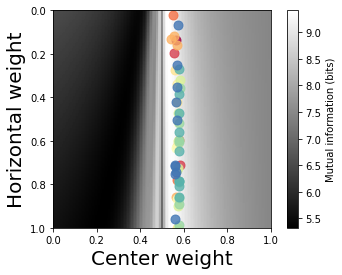

In [459]:
colors = plt.cm.Spectral(np.linspace(0,3,max_filters))
plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))

for channel_id in range(len(all_results)):
    all_hws = np.where(all_results[channel_id]['hw'][-1] > 1, 1, all_results[channel_id]['hw'][-1])
    all_cws = all_results[channel_id]['cw'][-1]

    for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
        plt.plot(cw, hw, color=colors[channel_id], marker='.', markersize=18, alpha=0.8)

# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

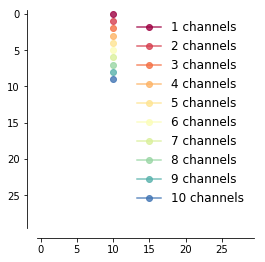

In [469]:
colors = plt.cm.Spectral(np.linspace(0,3,max_filters))
empty_map = np.zeros((max_filters,max_filters))
plt.imshow(empty_map, clim=[0,10], cmap='gray_r')
for channel_id in range(len(all_results)):
    plt.plot(10, channel_id, color=colors[channel_id], marker='.', 
                markersize=12, alpha=0.8, label='%d channels' %(channel_id+1))
plt.legend(frameon=False, fontsize=12)
adjust_spines(plt.gca())

In [474]:
all_results[-1]['labels'][0].shape

(128, 398)

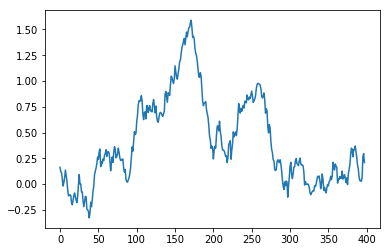

In [475]:
plt.plot(all_results[-1]['labels'][0][0])

In [476]:
all_results[-1].keys()

dict_keys(['input', 'labels', 'output', 'kernel', 'hw', 'cw', 'decoder', 'snr', 'snr_reg', 'input_noise', 'output_noise', 'label'])

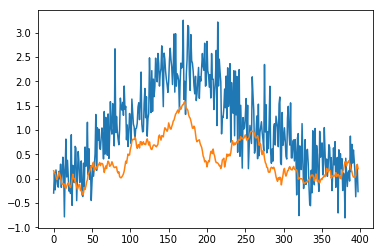

In [478]:
plt.plot(all_results[-1]['output'][0][0])
plt.plot(all_results[-1]['labels'][0][0])

In [479]:
np.mean((all_results[-1]['output'][0][0] - all_results[-1]['labels'][0][0])**2)

1.3443745976734056